In [1]:
import cv2
from src.utils.func import (crop_center, read_image_as_numpyimage, 
    pipette_color, apply_pht, _convert_hough_segments_to_lines,
    group_lines)
from src.utils.const import ref_snooker_playfield
from src.utils.playfield_finder import PlayfieldFinder
from src.utils.points import Point
from src.utils.lines import Line
import numpy as np
from src.utils.plotting import display_img, plot_on_image
import src.config

In [2]:
pic = read_image_as_numpyimage('pics/runda_5/pic_05_18_01.png', 'rgb') # pic_02_07_01.png   pic_05_18_01.png  pic_08_08_01.png pic_06_16_02.png
cropped_pic = crop_center(pic)

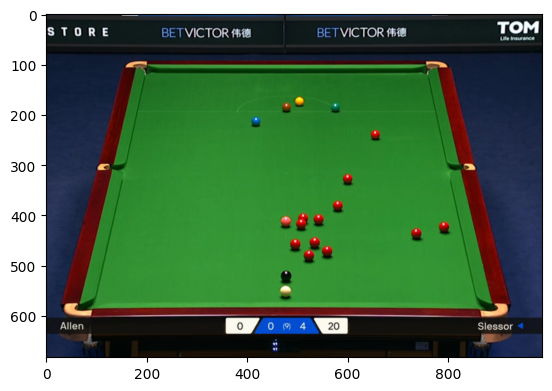

In [3]:
display_img(pic)

#### find playfield

In [4]:
finder = PlayfieldFinder(pic)

##### find internal side cushions

In [25]:
internal_side_cushions = finder.find_side_cushions()
internal_side_cushions = sorted(internal_side_cushions, key=lambda line: line.slope)
left_internal_side_cushion = internal_side_cushions[0]
right_internal_side_cushion = internal_side_cushions[1]

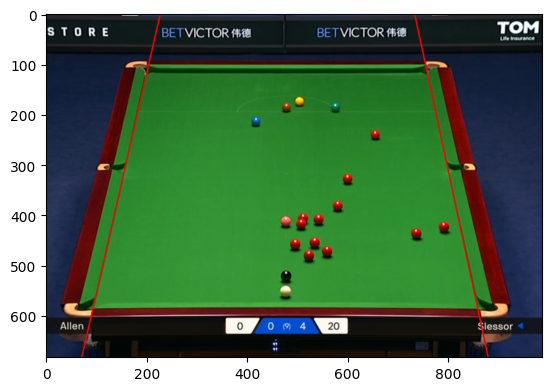

In [6]:
display_img(plot_on_image(pic, lines=internal_side_cushions))

##### find internal top cushion

In [7]:
internal_top_cushion = finder.find_top_internal_cushion()
internal_top_cushion

y = 0.0 * x + 109.0

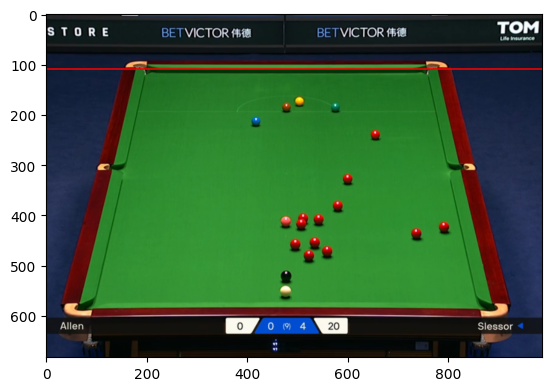

In [8]:
display_img(plot_on_image(pic, lines=[internal_top_cushion]))

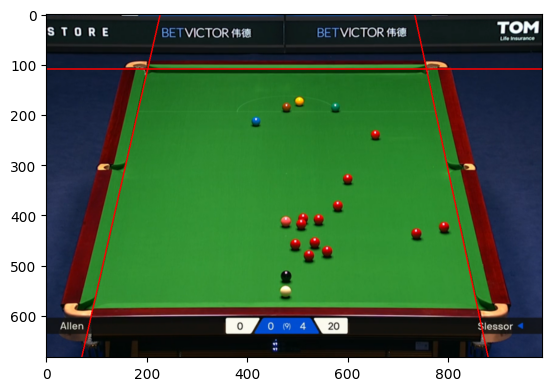

In [9]:
display_img(plot_on_image(pic, lines=[internal_top_cushion] + internal_side_cushions))

##### baulk line detection

In [10]:
baulk_line = finder.find_baulk_line()
baulk_line

y = 0.0 * x + 194.0

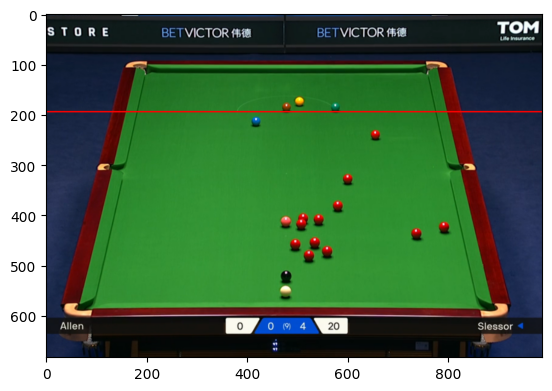

In [11]:
display_img(plot_on_image(pic, lines=[baulk_line]))

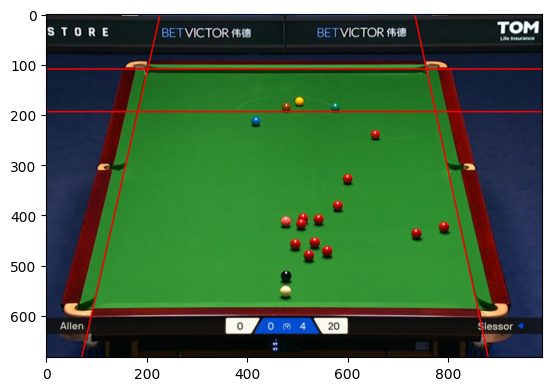

In [12]:
display_img(plot_on_image(pic, lines=[baulk_line] + [internal_top_cushion] + internal_side_cushions))

##### perspective transform

In [13]:
pic_copy = pic.copy()
# lines = [baulk_line] + [internal_top_cushion] + internal_side_cushions
# intersections = set()
# for group1 in lines:
#     for group2 in lines:
#         intersection = group1.intersection(group2, pic_copy)
#         if intersection is not None:
#             intersections.add(intersection.point)
            
# dst_points = sorted(list(intersections), key=lambda x: x.x)

In [14]:
baulk_left = baulk_line.intersection(left_internal_side_cushion, pic_copy)
top_left = left_internal_side_cushion.intersection(internal_top_cushion, pic_copy)
top_right = right_internal_side_cushion.intersection(internal_top_cushion, pic_copy)
baulk_right = baulk_line.intersection(right_internal_side_cushion, pic_copy)

In [15]:
dst_points = [baulk_left.point, top_left.point, top_right.point, baulk_right.point]

In [16]:
ref_points = ref_snooker_playfield()[1]
ref_points_arr = np.float32([ref_points[n].to_tuple() for n in ['baulk_left', 'top_left', 'top_right','baulk_right']])
dst_points_arr = np.float32(dst_points)

In [17]:
# display_img(ref_snooker_playfield()[0])

In [18]:
ref_points_arr

array([[    0.,  7366.],
       [    0.,     0.],
       [17780.,     0.],
       [17780.,  7366.]], dtype=float32)

In [19]:
dst_points_arr

array([[182., 194.],
       [202., 109.],
       [758., 109.],
       [776., 194.]], dtype=float32)

In [ ]:


H, _ = cv2.findHomography(ref_points_arr, dst_points_arr)

height, width = pic.height, pic.width

all_ref_points_arr = np.array([(p.x, p.y) for p in ref_points.values()], dtype=np.float32)[np.newaxis, ::]
transformed_points = cv2.perspectiveTransform(all_ref_points_arr, H)
coords = transformed_points[0]
transformed_points_dict = {name: Point(*(int(c) for c in coords[i])) for i, name in enumerate(ref_points.keys())}

In [21]:
# pic_copy = pic.copy()
# for point in transformed_points[0]:
#     x, y = point
    
#     cv2.circle(pic_copy, (int(x), int(y)), 5, (255, 0, 0), -1) 
# display_img(pic_copy)

In [22]:
bottom_left = transformed_points_dict['bottom_left']
bottom_right = transformed_points_dict['bottom_right']

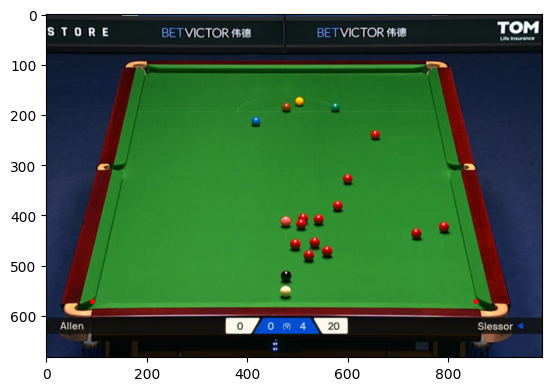

In [23]:
cv2.circle(pic, bottom_right.to_tuple(), 5, (255, 0, 0), -1)
cv2.circle(pic, bottom_left.to_tuple(), 5, (255, 0, 0), -1)
display_img(pic)

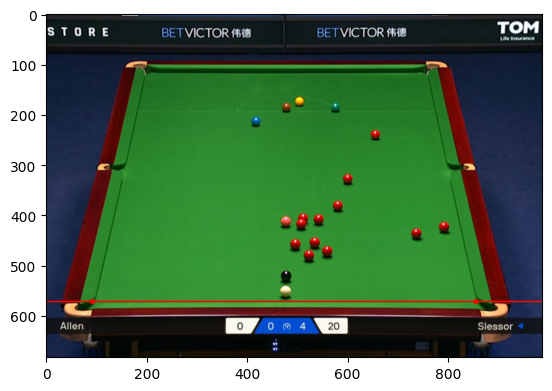

In [24]:
internal_bottom_cushion = Line.from_points(bottom_left, bottom_right)
display_img(plot_on_image(pic, lines=[internal_bottom_cushion]))